In [1]:
import numpy as np
import os

import copy

Set up variables for constants such as absolute datapaths and the desired valdiation fraction split.

In [2]:
#gnps
datapath = "G:\\Dev\\Data\\For Family\\GNPS Python Master\\Final Data.txt"
fingerprints_path = "G:\\Dev\\Data\\For Family\\GNPS Python Master\\Final Fingerprints.txt"
fingerprints_names_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Fingerprint Legend.txt"

#gnps for family
gnps_for_family_datapath = "G:\\Dev\\Data\\For Family Q3\\GNPS Python Master\\Final Data.txt"
fingerprints_for_family_gnps_path = "G:\\Dev\\Data\\For Family Q3\\GNPS Python Master\\Final Fingerprints.txt"

#mibig
mibig_fingerprints_path = "G:\\Dev\\Data\\Fingerprint Bitmaps 2\\mibig_unique_smiles.txt"
mibig_families_path = "G:\\Dev\\Data\\Final Families.txt"
mibig_filtered_fingerprints_path = "G:\\Dev\\Data\\Filtered Mibig GNPS Links\\Filtered Mibig Fingerprints.tsv"
mibig_filtered_families_path = "G:\\Dev\\Data\\mibig_family.txt"

#npatlas
npatlas_smiles_fingerprints_path = "G:\\Dev\\Data\\Fingerprint Bitmaps 2\\NPAtlas_DB_last_version_filtered.txt"
npatlas_final_families_path = "G:\\Dev\\Data\\NPAtlas_Final_Families.txt"

#test
test_datapath = "G:\\Dev\\Data\\For Family Test Q3\\GNPS Python Master\\Final Data.txt"
test_fingerprint_path = "G:\\Dev\\Data\\For Family Test Q3\\GNPS Python Master\\Final Fingerprints.txt"

linked_fingerprints_path = "G:\\Dev\\Data\\Linked GNPS Fingerprints.tsv"
families_names_path = "G:\\Dev\\Data\\Family Legend.txt"

num_samples = 5770
num_smiles_families_samples = 1368
val_fraction = 0.1

Import methods from ultilities

In [3]:
from nn_evaluation_interface import plot_loss, compute_auc, evaluate, compute_predicted_family_proportion
from nn_files_load_interface import *
from nn_interface import simplified_fingerprint_model, simplified_family_model
from nn_training_splits_interface import train_diff_splits

C:\Users\CherWei\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Load the data to variables

In [4]:
spectra = load_master_file(path=datapath)
fingerprints = load_fingerprints_master(path=fingerprints_path)

gnps_spectra = load_master_file(path=gnps_for_family_datapath)
gnps_fingerprints = load_fingerprints_master(path=fingerprints_for_family_gnps_path, number_of_rows=1)

mibig_fingerprints = load_fingerprints_master(path=mibig_fingerprints_path)
mibig_families = load_families_master(path=mibig_families_path)
mibig_filtered_fingerprints = load_fingerprints_master(path=mibig_filtered_fingerprints_path, number_of_rows=1)
mibig_filtered_families = load_families_master(path=mibig_filtered_families_path)

fingerprint_names = load_fingerprint_legend(path=fingerprints_names_path)
family_names = load_family_legend(path=families_names_path)

test_spectra = load_master_file(path=test_datapath)
test_fingerprint = load_fingerprints_master(path=test_fingerprint_path)

print("Done")

Done


The training/evaluation process

C:\Dev\nnpredict\Code\Python\nn_interface.py:117: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  auto_model = Model(input=input_layer, output=out_layer)


Train on 5702 samples, validate on 634 samples
Epoch 1/100
5702/5702 [==============================] - 7s 1ms/step - loss: 0.5492 - val_loss: 0.3557
Epoch 2/100
5702/5702 [==============================] - 4s 616us/step - loss: 0.2002 - val_loss: 0.1674
Epoch 3/100
5702/5702 [==============================] - 3s 593us/step - loss: 0.1251 - val_loss: 0.1344
Epoch 4/100
5702/5702 [==============================] - 3s 613us/step - loss: 0.1125 - val_loss: 0.1227
Epoch 5/100
5702/5702 [==============================] - 3s 611us/step - loss: 0.1077 - val_loss: 0.1167
Epoch 6/100
5702/5702 [==============================] - 3s 594us/step - loss: 0.1051 - val_loss: 0.1131
Epoch 7/100
5702/5702 [==============================] - 4s 635us/step - loss: 0.1034 - val_loss: 0.1106
Epoch 8/100
5702/5702 [==============================] - 4s 629us/step - loss: 0.1022 - val_loss: 0.1087
Epoch 9/100
5702/5702 [==============================] - 3s 610us/step - loss: 0.1012 - val_loss: 0.1073
Epoch 10/1

5702/5702 [==============================] - 7s 1ms/step - loss: 0.0814 - val_loss: 0.0870
Epoch 78/100
5702/5702 [==============================] - 6s 1ms/step - loss: 0.0813 - val_loss: 0.0869
Epoch 79/100
5702/5702 [==============================] - 5s 869us/step - loss: 0.0811 - val_loss: 0.0868ETA: 0s - loss:  - ETA: 0s - loss: 0
Epoch 80/100
5702/5702 [==============================] - 5s 907us/step - loss: 0.0810 - val_loss: 0.0867
Epoch 81/100
5702/5702 [==============================] - 5s 912us/step - loss: 0.0808 - val_loss: 0.0866TA: 0s - loss: 0.080
Epoch 82/100
5702/5702 [==============================] - 6s 1ms/step - loss: 0.0807 - val_loss: 0.0865
Epoch 83/100
5702/5702 [==============================] - 6s 970us/step - loss: 0.0805 - val_loss: 0.0864
Epoch 84/100
5702/5702 [==============================] - 6s 1ms/step - loss: 0.0804 - val_loss: 0.0863
Epoch 85/100
5702/5702 [==============================] - 5s 876us/step - loss: 0.0802 - val_loss: 0.0862
Epoch 86/10

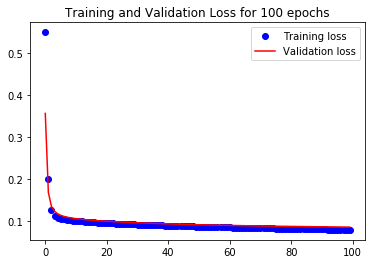

Done


In [5]:
# Training network 1 (exclude links)
epochs = 100
x_train_spectra = np.log(gnps_spectra+1)
x_train_fingerprints = gnps_fingerprints.values
x_test_spectra = np.log(test_spectra+1)

enc1 = simplified_fingerprint_model(x_train_spectra, x_train_fingerprints, epochs=epochs)

actual = test_fingerprint.values
predicted = enc1.predict(x_test_spectra)

n1_stats, n1_perm_scores = compute_auc(320, actual, predicted)

C:\Dev\nnpredict\Code\Python\nn_interface.py:157: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  auto_model = Model(input=input_layer, output=out_layer)


Train on 1165 samples, validate on 130 samples
Epoch 1/100
1165/1165 [==============================] - 2s 2ms/step - loss: 0.5824 - val_loss: 0.4533
Epoch 2/100
1165/1165 [==============================] - 1s 831us/step - loss: 0.3965 - val_loss: 0.3449
Epoch 3/100
1165/1165 [==============================] - 1s 891us/step - loss: 0.3440 - val_loss: 0.3192
Epoch 4/100
1165/1165 [==============================] - 1s 835us/step - loss: 0.3281 - val_loss: 0.3083
Epoch 5/100
1165/1165 [==============================] - 1s 667us/step - loss: 0.3179 - val_loss: 0.3008
Epoch 6/100
1165/1165 [==============================] - 1s 903us/step - loss: 0.3096 - val_loss: 0.2947
Epoch 7/100
1165/1165 [==============================] - 1s 737us/step - loss: 0.3021 - val_loss: 0.2894
Epoch 8/100
1165/1165 [==============================] - 1s 779us/step - loss: 0.2955 - val_loss: 0.2848
Epoch 9/100
1165/1165 [==============================] - 1s 903us/step - loss: 0.2894 - val_loss: 0.2806
Epoch 10/1

1165/1165 [==============================] - 1s 844us/step - loss: 0.1634 - val_loss: 0.2024
Epoch 78/100
1165/1165 [==============================] - 1s 914us/step - loss: 0.1627 - val_loss: 0.2022
Epoch 79/100
1165/1165 [==============================] - 1s 800us/step - loss: 0.1621 - val_loss: 0.2020
Epoch 80/100
1165/1165 [==============================] - 1s 902us/step - loss: 0.1614 - val_loss: 0.2017
Epoch 81/100
1165/1165 [==============================] - 1s 771us/step - loss: 0.1607 - val_loss: 0.2015
Epoch 82/100
1165/1165 [==============================] - 1s 971us/step - loss: 0.1600 - val_loss: 0.2014
Epoch 83/100
1165/1165 [==============================] - 1s 829us/step - loss: 0.1594 - val_loss: 0.2012
Epoch 84/100
1165/1165 [==============================] - 1s 927us/step - loss: 0.1587 - val_loss: 0.2010
Epoch 85/100
1165/1165 [==============================] - 1s 887us/step - loss: 0.1581 - val_loss: 0.2009
Epoch 86/100
1165/1165 [==============================] - 1

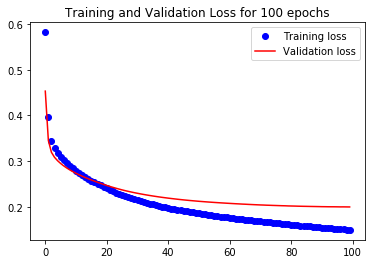

In [6]:
# Training network 2 (exclude links)
epochs = 100
x_train_fingerprints = mibig_filtered_fingerprints
x_train_families = mibig_filtered_families

enc2 = simplified_family_model(x_train_fingerprints.values, x_train_families.values, epochs=epochs)

In [7]:
# using linked mibig-gnps as test set
x_train_spectra = load_master_file(path=test_datapath)
predicted = enc1.predict(x_train_spectra)

gnps_families_path = "G:\\Dev\\Data\\gnps_family.txt"
x_train_families = load_families_master(gnps_families_path)
x_train_fingerprints = load_fingerprints_master(test_fingerprint_path, number_of_rows=1)

actual = x_train_families.values
predicted = enc2.predict(predicted) # using predicted fingerprints
exp_stats, exp_perm_scores = compute_auc(8, actual, predicted)

print(exp_stats)
print()
print(exp_perm_scores)
print()

Done
[(0, 14, 0.83282675,   0. ) (1, 63, 0.59278292,   1.8)
 (2,  7, 0.67032967,   6. ) (3, 12, 0.42850877,  78.4)
 (4,  0, 0.        , 100. ) (5, 10, 0.534375  ,  33. )
 (6, 91, 0.57459657,   2.2) (7, 23, 0.52926889,  29.4)]

[[0.49620061 0.54711246 0.4806231  ... 0.4631459  0.55547112 0.59460486]
 [0.53317346 0.50359712 0.52769213 ... 0.52278177 0.46808268 0.48110083]
 [0.61172161 0.72967033 0.7047619  ... 0.52820513 0.46153846 0.65128205]
 ...
 [0.53489583 0.47708333 0.5265625  ... 0.3921875  0.43333333 0.67708333]
 [0.44421344 0.3983764  0.48648649 ... 0.54034254 0.48955549 0.52232452]
 [0.49429196 0.44668448 0.44352684 ... 0.46247267 0.44352684 0.53266942]]



In [8]:
compute_predicted_family_proportion(gnps_families_path, family_names, x_train_families.index, predicted)

Family, proportion guessed correctly, proportion missed
Alkaloid, 7.142857142857142, 2.912621359223301
NRP, 14.285714285714285, 11.464968152866243
Terpene, 14.285714285714285, 3.755868544600939
RiPP, 0.0, 0.0
Nucleoside no sample
Saccharide, 0.0, 0.0
Polyketide, 78.02197802197803, 59.68992248062015
Other, 0.0, 5.583756345177665


In [9]:
predicted = enc2.predict(x_train_fingerprints.values) # using true fingerprints
exp_stats, exp_perm_scores = compute_auc(8, actual, predicted)

print(exp_stats)
print()
print(exp_perm_scores)
print()

Done
[(0, 14, 0.96086626,   0. ) (1, 63, 0.69213201,   0. )
 (2,  7, 0.75091575,   1.2) (3, 12, 0.91622807,   0. )
 (4,  0, 0.        , 100. ) (5, 10, 0.93177083,   0. )
 (6, 91, 0.95099495,   0. ) (7, 23, 0.77507894,   0. )]

[[0.62329027 0.49392097 0.375      ... 0.39608663 0.5799772  0.52944529]
 [0.4555213  0.4918922  0.50845038 ... 0.50782231 0.54984584 0.41561037]
 [0.58315018 0.50915751 0.38681319 ... 0.56080586 0.55787546 0.64798535]
 ...
 [0.5125     0.490625   0.48333333 ... 0.48645833 0.60286458 0.5921875 ]
 [0.47742798 0.43352143 0.4956935  ... 0.58202158 0.48019998 0.53539254]
 [0.51821715 0.44595579 0.62035463 ... 0.58829245 0.42834588 0.51032305]]



In [10]:
compute_predicted_family_proportion(gnps_families_path, family_names, x_train_families.index, predicted)

Family, proportion guessed correctly, proportion missed
Alkaloid, 42.857142857142854, 0.0
NRP, 31.746031746031743, 10.191082802547772
Terpene, 28.57142857142857, 2.8169014084507045
RiPP, 25.0, 0.0
Nucleoside no sample
Saccharide, 40.0, 0.0
Polyketide, 93.4065934065934, 34.10852713178294
Other, 43.47826086956522, 3.0456852791878175


In [11]:
# using mibig all as test dataset
x_train_fingerprints = mibig_fingerprints
x_train_families = mibig_families

actual = x_train_families.values
predicted = enc2.predict(x_train_fingerprints.values) # using true fingerprints
exp_stats, exp_perm_scores = compute_auc(8, actual, predicted)

print(exp_stats)
print()
print(exp_perm_scores)
print()

Done
[(0,  90, 0.97772865,  0. ) (1, 505, 0.91983456,  0. )
 (2, 131, 0.9737929 ,  0. ) (3,  72, 0.98613636,  0. )
 (4,   1, 0.51659751, 46.8) (5, 103, 0.97529473,  0. )
 (6, 722, 0.93793294,  0. ) (7, 189, 0.90093875,  0. )]

[[0.51190944 0.5155531  0.53762384 ... 0.47758536 0.48960943 0.50032752]
 [0.50861239 0.52915011 0.5224002  ... 0.5117477  0.492713   0.49089046]
 [0.51274392 0.48961403 0.50696942 ... 0.5348732  0.48929209 0.49500278]
 ...
 [0.48634348 0.46313352 0.49051881 ... 0.5368448  0.51527465 0.4906055 ]
 [0.493902   0.53300793 0.52781163 ... 0.49750501 0.4830127  0.48846881]
 [0.50209033 0.50799329 0.4904253  ... 0.49411596 0.47470159 0.48581985]]



In [12]:
compute_predicted_family_proportion(mibig_families_path, family_names, x_train_families.index, predicted)

Family, proportion guessed correctly, proportion missed
Alkaloid, 41.11111111111111, 0.4643064422518862
NRP, 65.34653465346535, 4.969418960244648
Terpene, 70.22900763358778, 0.8323424494649228
RiPP, 69.44444444444444, 0.5169442848937392
Nucleoside, 0.0, 0.0
Saccharide, 20.388349514563107, 0.11695906432748539
Polyketide, 83.10249307479224, 8.340971585701192
Other, 49.735449735449734, 2.0935960591133003


In [21]:
family_common_fingerprint_path = "G:\\Dev\\Data\\family_common_substructures.txt"
family_substructure_auc_path = "G:\\Dev\\Data\\family_substructure_auc.txt"
family_substructure_auc = {}
n1_stats = list(n1_stats)

with open(family_common_fingerprint_path, 'r') as f:
    for line in f:
        family, bit_name, occurrence, occurence_other, diff = line.split("  ")
        if family not in family_substructure_auc:
            family_substructure_auc[family] = {}
        family_substructure_auc[family][bit_name] = n1_stats[fingerprint_names.index(bit_name)][2]

with open(family_substructure_auc_path, 'w') as f:
    for key, details in family_substructure_auc.items():
        for substructure, auc in details.items():
            f.write(key + "," + substructure + "," + str(round(auc,2)) + "\n")

In [ ]:
# Training network 1 (include links)
epochs = 100
x_train_spectra = np.log(spectra+1)
x_train_fingerprints = fingerprints.values

enc1 = simplified_fingerprint_model(x_train_spectra, x_train_fingerprints, epochs=epochs)

C:\Dev\nnpredict\Code\Python\nn_interface.py:157: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  auto_model = Model(input=input_layer, output=out_layer)


Train on 1231 samples, validate on 137 samples
Epoch 1/100
1231/1231 [==============================] - 1s 902us/step - loss: 0.5226 - val_loss: 0.3818
Epoch 2/100
1231/1231 [==============================] - 1s 451us/step - loss: 0.3585 - val_loss: 0.3259
Epoch 3/100
1231/1231 [==============================] - 1s 635us/step - loss: 0.3297 - val_loss: 0.3123
Epoch 4/100
1231/1231 [==============================] - 1s 692us/step - loss: 0.3170 - val_loss: 0.3045
Epoch 5/100
1231/1231 [==============================] - 1s 563us/step - loss: 0.3073 - val_loss: 0.2983
Epoch 6/100
1231/1231 [==============================] - 1s 634us/step - loss: 0.2990 - val_loss: 0.2928
Epoch 7/100
1231/1231 [==============================] - 1s 553us/step - loss: 0.2917 - val_loss: 0.2878
Epoch 8/100
1231/1231 [==============================] - 1s 469us/step - loss: 0.2852 - val_loss: 0.2833
Epoch 9/100
1231/1231 [==============================] - 0s 395us/step - loss: 0.2793 - val_loss: 0.2792
Epoch 10

Epoch 78/100
1231/1231 [==============================] - 1s 555us/step - loss: 0.1653 - val_loss: 0.2089
Epoch 79/100
1231/1231 [==============================] - 1s 531us/step - loss: 0.1646 - val_loss: 0.2086
Epoch 80/100
1231/1231 [==============================] - 1s 563us/step - loss: 0.1639 - val_loss: 0.2084
Epoch 81/100
1231/1231 [==============================] - 1s 528us/step - loss: 0.1631 - val_loss: 0.2082
Epoch 82/100
1231/1231 [==============================] - 1s 504us/step - loss: 0.1624 - val_loss: 0.2080
Epoch 83/100
1231/1231 [==============================] - 1s 524us/step - loss: 0.1617 - val_loss: 0.2078
Epoch 84/100
1231/1231 [==============================] - 1s 501us/step - loss: 0.1610 - val_loss: 0.2076
Epoch 85/100
1231/1231 [==============================] - 1s 563us/step - loss: 0.1603 - val_loss: 0.2074
Epoch 86/100
1231/1231 [==============================] - 1s 531us/step - loss: 0.1596 - val_loss: 0.2072
Epoch 87/100
1231/1231 [======================

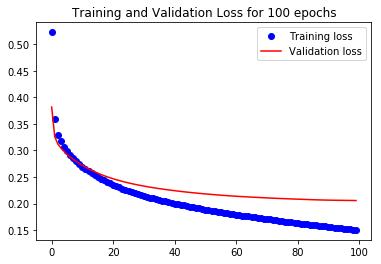

In [12]:
# Training network 2 (include links)
epochs = 100
x_train_fingerprints = mibig_fingerprints
x_train_families = mibig_families

enc2 = simplified_family_model(x_train_fingerprints.values, x_train_families.values, epochs=epochs)

In [ ]:
mibig_links_path = "G:\\Dev\\Data\\mibig_gnps_links_q3_loose.csv"
mibig_family_path = "G:\\Dev\\Data\\mibig_family\\gene_family.txt"
mibig_gnps_df = pd.read_csv(mibig_links_path, sep=",")

mibig_gnps_dict = {}
mibig_families = {}
mibig_families_count = {}

for index, row in mibig_gnps_df.iterrows():
    if row["gnps_id"] not in mibig_gnps_dict:
        mibig_gnps_dict[row["gnps_id"]] = set()
    mibig_gnps_dict[row["gnps_id"]].add(row["#mibig_id"])

with open(mibig_family_path, 'r') as f:
    for line in f:
        mibig_id, family = line.split("  ")
        if mibig_id not in mibig_families:
            mibig_families[mibig_id] = []
        mibig_families[mibig_id].append(family[:-1])
        
probability_report_path = "G:\\Dev\\Data\\gnps_prediction_report.csv"
families = ["Alkaloid", "NRP", "Terpene", "RiPP", "Nucleoside", "Saccharide", "Polyketide", "Other"]
true_family_counter = {}
family_correct_counter = {}

for family in families:
    true_family_counter[family] = 0
    family_correct_counter[family] = 0

with open(probability_report_path, 'w') as f:
    f.write("#mibig_id,gnps_id,Alkaloid,NRP,Terpene,RiPP,Nucleoside,Saccharide,Polyketide,Other,True Label\n")

with open(probability_report_path, 'a') as f:    
    for index, probabilities in enumerate(predicted):
        temp = copy.deepcopy(probabilities).tolist()
        gnps_id = x_train_fingerprints.index[index]
        prob_string = ",".join(map(str, probabilities))
        for mibig_id in mibig_gnps_dict[gnps_id]:
            true_labels = []
            max_indexes = []
            for true_family in mibig_families[mibig_id]:
                true_labels.append(true_family)
                max_index = temp.index(max(temp))
                max_indexes.append(max_index)
                temp.remove(temp[max_index])
                true_family_counter[true_family] += 1
                f.write(mibig_id + "," + gnps_id + "," + prob_string + "," + true_family + "\n")
            for index in max_indexes:
                if families[index] in true_labels:
                    family_correct_counter[families[index]] += 1
    
prediction_comparison_report_path = "G:\\Dev\\Data\\prediction_comparison_report.txt"
with open(prediction_comparison_report_path, 'w') as f:
    f.write("family,matched,actual,proportion\n")

with open(prediction_comparison_report_path, 'a') as f:
    for family in family_correct_counter:
        matched = family_correct_counter[family]
        actual = true_family_counter[family]
        proportion = 0
        if actual != 0:
            proportion = matched / actual
        f.write(family + "," + str(matched) + "," + str(actual) + "," + str(proportion*100) + "\n")
    
print("Done")

In [ ]:
filepath = "G:\\Dev\\Data\\saved_spectrum_fingerprint_non_binary_model.h5"
enc1.save(filepath)

filepath = "G:\\Dev\\Data\\saved_fingerprint_families_non_binary_model.h5"
enc2.save(filepath)